# COMP5328 - Advanced Machine Learning

## Assignment 1: Non-negative Matrix Factorization(final version)

### 0. Runtime Initiation & Package Loading

In [49]:
# # colab runtime
# # mount google dirve
# #
# from google.colab import drive
# import zipfile

# drive.mount('/content/drive')

# with zipfile.ZipFile('/content/drive/MyDrive/usyd/COMP5328/data.zip', 'r') as zip_ref:
#     zip_ref.extractall("/home/")

# DATA_ROOT = "/home/"

time: 175 µs (started: 2023-10-08 00:03:13 +11:00)


In [60]:
# local runtime
DATA_ROOT = "./"

In [58]:
import os
import numpy as np
from PIL import Image
from numpy import sqrt
import matplotlib.pyplot as plt
from skimage.transform import resize
from time import time
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import random

### 1. Load Dataset

#### 1.1 Load ORL Dataset and Extended YaleB Dataset.
- ORL dataset contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement). The size of each image is 92x112 pixels, with 256 grey levels per pixel. To further reduce the computation complexity, you can resize all images to 30x37 pixels.

- Extended YaleB dataset contains 2414 images of 38 human subjects under 9 poses and 64 illumination conditions. All images are manually aligned, cropped, and then resized to 168x192 pixels. To further reduce the computation complexity, you can resize all images to 42x48 pixels.

In [54]:
def load_data(root='data/CroppedYaleB', reduce=4):
    """
    Load ORL (or Extended YaleB) dataset to numpy array.

    Args:
        root: path to dataset.
        reduce: scale factor for zooming out images.
    return:
        images: (400, 11110)
        image_data: (400, 30, 37)
        Y
    """
    images, image_data, labels = [], [], []

    for i, person in enumerate(sorted(os.listdir(root))):

        if not os.path.isdir(os.path.join(root, person)):
            continue

        for fname in os.listdir(os.path.join(root, person)):

            # Remove background images in Extended YaleB dataset.
            if fname.endswith('Ambient.pgm'):
                continue

            if not fname.endswith('.pgm'):
                continue

            # load image.
            img = Image.open(os.path.join(root, person, fname))
            img = img.convert('L') # grey image.

            # reduce computation complexity.
            img = img.resize([s//reduce for s in img.size])

            img_data = np.asarray(img)

            # convert image to numpy array.
            img = np.asarray(img).reshape((-1,1))

            # collect data and label.
            images.append(img)
            image_data.append(img_data)

            labels.append(i)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    image_data = np.stack(image_data)
    labels = np.array(labels)

    return images, image_data, labels

#### 1.2 Load AR Dataset (Not used)
AR dataset contains 2600 images of 100 individuals (50 male and 50 female). All images have been cropped and resized to 120x165 pixels. To further reduce the computation complexity, you can resize all images to 40x55 pixels.

In [54]:
def load_data_AR(root='data/CroppedAR', reduce=3):
    """
    Load AR dataset to numpy array.

    Args:
        root: path to AR dataset.
        reduce: scale factor for zooming out images.

    """
    images, labels = [], []

    for fname in os.listdir(root):

        if not fname.endswith('.bmp'):
            continue

        # get label.
        label = int(fname[2:5])
        if fname[0] == 'W': # start from 50
            label += 50

        # load image.
        img = Image.open(os.path.join(root, fname))
        img = img.convert('L') # grey

        # reduce computation complexity.
        img = img.resize([s//reduce for s in img.size])

        # TODO: preprocessing.

        # convert image to numpy array.
        img = np.asarray(img).reshape((-1,1))

        # collect data and label.
        images.append(img)
        labels.append(label)

    # concate all images and labels.
    images = np.concatenate(images, axis=1)
    labels = np.array(labels)

    return images, labels

time: 622 µs (started: 2023-10-08 00:03:14 +11:00)


### 2. Helper Functions

In [62]:
def transform21d(data):
    data_arr = []
    for img in data:
        data_arr.append(img.reshape(np.prod(data[0].shape)))
    return np.stack(data_arr)

def transform22d(data, size=(37,30)):
    data_arr = []
    for img in data:
        data_arr.append(img.reshape(size))
    return np.stack(data_arr)

### 3. Noise Implementation

#### 3.1 Block Occlusion Noise

In [58]:
class BlockOcclusion():

    def __init__(self, shape = (30,37), size = None, random_state = None):
        self.random_state = random_state
        if size is None:
            size = random.randint(4,8)
        self.mask = self._create_mask(shape,size)

    def _create_mask(self, shape, size):
        mask = np.zeros(shape=shape)
        random.seed(self.random_state)
        start_row = random.randint(0,shape[0] - 1 - size)
        random.seed(self.random_state)
        start_column = random.randint(0,shape[1] - 1 - size)

        mask[start_row:start_row+size, start_column:start_column+size] = 1
        mask = mask.reshape(-1)
        return mask

    def occlusde(self, X):
        x = X.copy()

        for i in range(len(x)):
            if self.mask[i] == 1:
                x[i] = 255

        return x

time: 509 µs (started: 2023-10-08 00:03:14 +11:00)


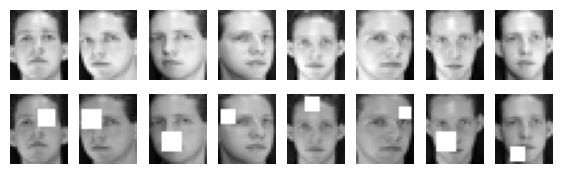

time: 180 ms (started: 2023-10-08 00:03:14 +11:00)


In [59]:
X_hat, X_data, Y_hat = load_data(root=DATA_ROOT+'data/ORL', reduce=4)
img_size = X_data[0].shape

X_test = X_hat[:,0:8]
# generate Block noise data
X_block_noise_test = np.zeros(X_test.shape)
for i in range(X_test.shape[1]):
    X_block_noise_test[:,i] = BlockOcclusion(img_size).occlusde(X_test[:,i])

X_block_test = np.concatenate((X_test,X_block_noise_test),axis=1)

fig, axes = plt.subplots(2,8,figsize=(7, 2))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(X_block_test[:,i].reshape(img_size),cmap=plt.cm.gray)
    ax.axis('off')

plt.show()

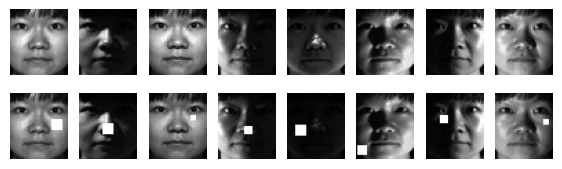

time: 471 ms (started: 2023-10-08 00:03:14 +11:00)


In [60]:
X_hat, X_data, Y_hat = load_data(root=DATA_ROOT+'data/CroppedYaleB', reduce=4)
img_size = X_data[0].shape

X_test = X_hat[:,300:308]
# generate Block noise data
X_block_noise_test = np.zeros(X_test.shape)
for i in range(X_test.shape[1]):
    X_block_noise_test[:,i] = BlockOcclusion(img_size).occlusde(X_test[:,i])

X_block_test = np.concatenate((X_test,X_block_noise_test),axis=1)

fig, axes = plt.subplots(2,8,figsize=(7, 2))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(X_block_test[:,i].reshape(img_size),cmap=plt.cm.gray)
    ax.axis('off')

plt.show()

#### 3.2 Pepper and Salt Noise

In [55]:
def gen_salt_pepper_noise(data, threshold=0.05):
    """
    Generate salt and pepper noise on orginal data

    Args:
        threshold: percentage of noise of total pixels

    return: new noise data
    """
    img_shape = data[0].shape
    tot_pixels = np.prod(img_shape)
    num_occ = int(threshold * tot_pixels)
    # num_w_occ = int(num_occ * b_w_threshold)

    occ_data = data.copy()

    for occ_img in occ_data:
        ran_w_idx = np.random.choice(tot_pixels, num_occ, replace=False)
        # ran_b_idx = np.random.choice(tot_pixels, num_occ-num_w_occ, replace=False)
        w_ridx, w_cidx = np.unravel_index(ran_w_idx, occ_img.shape)
        occ_img[w_ridx, w_cidx] = 255
        # b_ridx, b_cidx = np.unravel_index(ran_b_idx, occ_img.shape)
        # occ_img[b_ridx, b_cidx] = 0

    return occ_data

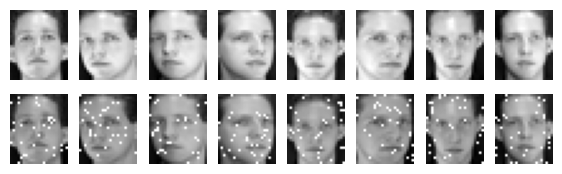

time: 213 ms (started: 2023-10-08 00:03:15 +11:00)


In [62]:
X_hat, X_data, Y_hat = load_data(root=DATA_ROOT+'data/ORL', reduce=4)
img_size = X_data[0].shape

X_test = X_hat[:,0:8]
# generate salt noise data
X_salt_noise_test = transform21d(gen_salt_pepper_noise(X_data, 0.05)).T

X_block_test = np.concatenate((X_test,X_salt_noise_test),axis=1)

fig, axes = plt.subplots(2,8,figsize=(7, 2))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(X_block_test[:,i].reshape(img_size),cmap=plt.cm.gray)
    ax.axis('off')

plt.show()

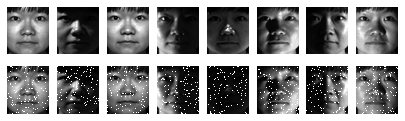

In [66]:
X_hat, X_data, Y_hat = load_data(root=DATA_ROOT+'data/CroppedYaleB', reduce=4)
img_size = X_data[0].shape

X_test = X_hat[:,300:308]
X_salt_noise_test = transform21d(gen_salt_pepper_noise(X_data, 0.05)).T

X_salt_test = np.concatenate((X_test,X_salt_noise_test[:, 300:308]),axis=1)

fig, axes = plt.subplots(2,8,figsize=(7, 2))

for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(X_salt_test[:,i].reshape(img_size),cmap=plt.cm.gray)
    ax.axis('off')

plt.show()

### 4. Evaluation Metrics

#### 4.1 Root Means Square Errors (RMSE)
To compare the robustness of different NMF algorithms, you can use the Root Means Square Errors. Let $X$ denote the contaminated dataset (by adding noise), and  $\hat X$  denote the clean dataset. Let  $R$ and  $D$ denote the factorization results on $𝑉$, Root Means Square Errors then can be defined as follows:
$RMSE= ||\hat X - RD||_F$

In [64]:
def eval_rmse(X_clean, U, V):
  return sqrt(np.linalg.norm(X_clean - U @ V)/len(X_clean))
  # return sqrt(mean_squared_error(X_clean, U.dot(V))/len(X_clean))

time: 192 µs (started: 2023-10-08 00:03:15 +11:00)


#### 4.2 Evaluate Clustering Performance (Accuracy)

  $Acc(Y, Y_{pred}) = \frac{1}{n}\sum_{i=1}^n 1\{Y_{pred(i)} == Y(i)\}$
  

In [65]:
def assign_cluster_label(X, Y):
  kmeans = KMeans(n_clusters=len(set(Y)),n_init=10).fit(X)
  Y_pred = np.zeros(Y.shape)
  for i in set(kmeans.labels_):
      ind = kmeans.labels_ == i
      Y_pred[ind] = Counter(Y[ind]).most_common(1)[0][0] # assign label.
  return Y_pred

time: 233 µs (started: 2023-10-08 00:03:15 +11:00)


In [66]:
def eval(X_clean, Y, D, R):
    """
    Evaluate NMF Algorithm

    Args:
        X: clean image data
        Y: class
        D: dictionary
        R: representation
    """
    # Assign cluster labels.
    Y_pred = assign_cluster_label(D, Y)
    # print('==> Evaluate Acc ...')
    acc = accuracy_score(Y, Y_pred)
    nmi = normalized_mutual_info_score(Y, Y_pred)
    # print('Acc = {:.4f}'.format(acc))
    # Evaluate Root Means Square Errors .
    # print('==> Evaluate RMSE ...')
    RMSE = eval_rmse(X_clean, D, R)
    # print('RMSE = {}'.format(RMSE))
    return [acc, nmi, RMSE]

time: 249 µs (started: 2023-10-08 00:03:15 +11:00)


### 5. NMF Implementations

#### 5.1 L2,1-Norm based NMF

In [67]:
class NMFL21:
    """
    the code structure is followed by scikit-learn.

    X: m * n
    Component: m * k
    Code: k * n
    """
    def __init__(
        self,
        n_components=None,
        max_iter=1000,
        random_state=None,
        tol=1e-8,
        alpha=None, # only for be compatible
        ):
        'Initialization'
        self.n_components = n_components
        self.max_iter = max_iter
        self.random_state = random_state
        self.tol = tol

    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.code_

    def fit(self, X_hat, X, y = None):
        M = X.shape[0]
        N = X.shape[1]
        if self.n_components is None:
            n_components = X.shape[1]
        else:
            n_components = self.n_components

        rng = np.random.RandomState(self.random_state)
        dictionary = rng.random((M,n_components))
        code = rng.random((n_components,N))

        D = np.zeros((N,N))
        errors = {
            'rmse':[],
            'acc':[],
            'nmi':[],
        }
        tol = self.tol

        best_score = 0

        for step in range(self.max_iter):
            for i in range(N):
                D[i][i] = 1 / np.linalg.norm(X[:,i] - dictionary @ code[:,i])

            dictionary_new = dictionary * (X @ D @ code.T / (dictionary @ code @ D @ code.T)) + 1e-7
            code_new = code * (dictionary_new.T @ X @ D / (dictionary_new.T @ dictionary_new @ code @ D)) + 1e-7

            e_dict = np.sqrt(np.sum((dictionary_new-dictionary)**2, axis=(0,1)))/dictionary_new.size
            e_code = np.sqrt(np.sum((code_new-code)**2, axis=(0,1)))/code_new.size

            dictionary = dictionary_new
            code = code_new

            # RMSE
            rmse = sqrt(np.linalg.norm(X_hat - dictionary @ code)/N)
            # ACC
            y_pred = assign_cluster_label(code.T, y)
            acc = accuracy_score(y, y_pred)
            # NMI
            nmi = normalized_mutual_info_score(y, y_pred)

            if acc > best_score:
                best_score = acc
                self.best_components_ = dictionary
                self.best_code_ = code
                self.best_rmse_ = rmse
                self.best_acc_ = acc
                self.best_nmi_ = nmi
                self.best_iteration_ = step + 1

            errors['rmse'].append(rmse)
            errors['acc'].append(acc)
            errors['nmi'].append(nmi)

            if e_dict < tol and e_code < tol:
                print("--- Convergence reached after %d iterations" % (step + 1))
                break

        self.components_ = dictionary
        self.code_ = code
        self.error_ = errors

        return self
    

    def reconstruct(self, i):
        return self.best_components_ @ self.best_code_[:,i]

time: 1 ms (started: 2023-10-08 00:03:15 +11:00)


#### 5.2 Robust NMF via L1 Norm Regularization

In [68]:
class RobustNMFL1Reg():
    def __init__(
        self,
        n_components=None,
        alpha=0.01,
        max_iter=100,
        random_state=5328):
        self.n_components = n_components
        self.alpha = alpha
        self.n_iter = max_iter
        self.rng = np.random.RandomState(random_state)
        self.U = None
        self.V = None
        self.E = None
        self.info = {
                    'rmse':[],
                    'acc':[],
                    'nmi':[],
                }

    def _init(self, M, N, K):

      # randomly generate number betwee 0 to 1
      self.U = self.rng.rand(M, K)
      self.V = self.rng.rand(K, N)
      self.E = self.rng.rand(M, N)

    def _gen_reconstructed_img(self):
        return  self.U.dot(self.V)

    def _update_u(self, X_noise):
        numerator = (X_noise - self.E).dot(self.V.T)
        denom = self.U.dot(self.V).dot(self.V.T)
        self.U = self.U * (numerator / denom)

    def _update_v_ep_en(self, X_noise, E_p, E_n):
        V_hat = np.concatenate((self.V, E_p, E_n), axis=0)
        X_hat = np.concatenate((X_noise, np.zeros(len(X_noise[0])).reshape(1,-1)), axis=0)
        # print("V_hat.shape: ", V_hat.shape)
        # print("X_hat.shape: ", X_hat.shape) # (401, 1110)
        I = np.eye(len(self.U))
        U_hat_upper = np.concatenate((self.U, I, -I), axis=1)
        # print("self.U.shape: ", self.U.shape)
        # print("U_hat_upper.shape: ", U_hat_upper.shape)
        k_zeros = np.zeros(self.n_components)
        tmp_alpha = np.full(len(X_noise), sqrt(self.alpha))
        # print("k_zeros.shape: ", k_zeros.shape)
        # print("tmp_alpha.shape: ", tmp_alpha.shape)
        U_hat_bottm = np.concatenate((k_zeros, tmp_alpha, tmp_alpha))[np.newaxis, :]
        # print("U_hat_bottm.shape: ", U_hat_bottm.shape)
        U_hat = np.concatenate((U_hat_upper, U_hat_bottm), axis=0)
        # print("U_hat.shape: ", U_hat.shape)
        S = U_hat.T.dot(U_hat)
        # print("S.shape: ", S.shape)

        denom = S.dot(V_hat)
        # print("denom.shape: ", denom.shape)
        # print(U_hat.T.dot(U_hat).shape)
        eq1 = V_hat *( U_hat.T.dot(U_hat).dot(V_hat)) / denom
        eq2 = V_hat * (U_hat.T.dot(X_hat)) / denom

        V_hat = np.maximum(0, V_hat - eq1 + eq2)
        # print("v_hat.shape: ", V_hat.shape )

        # split to v, e_p, e_n
        self.V = V_hat[:self.n_components, :]
        E_p = V_hat[self.n_components:self.n_components+len(X_noise), :]
        E_n = V_hat[self.n_components+len(X_noise):, :]
        return E_p, E_n

    def fit(self, X_clean, X_noise, Y=None):

        M, N, K= len(X_noise), len(X_noise[0]), self.n_components

        # initialize dictionary, representation, noise
        self._init(M, N, K)

        best_score = 0

        # train
        for i in range(self.n_iter):

            # multiplicative update

            # update U
            self._update_u(X_noise)

            # update V, E_p, E_n

            # init E_p, E_n
            E_p = (np.abs(self.E) + self.E) / 2
            E_n = (np.abs(self.E) - self.E) / 2

            update_E_p, update_E_n = self._update_v_ep_en(X_noise, E_p, E_n)

            self.E = update_E_p - update_E_n
            tup = eval(X_clean, Y, self.U, self.V)

            # acc
            if tup[0] > best_score:
                best_score = tup[0]
                self.best_components_ = self.V.T
                self.best_code_ = self.U.T
                self.best_rmse_ = tup[2]
                self.best_acc_ = tup[0]
                self.best_nmi_ = tup[1]
                self.best_iteration_ = i + 1
            
            
            self.info['acc'].append(tup[0])
            self.info['nmi'].append(tup[1])
            self.info['rmse'].append(tup[2])

         # to be compatible with NMFL21
        self.components_ = self.V.T
        self.code_ = self.U.T
        self.error_ = self.info

        return self
    

    def reconstruct(self, i):
        return self.best_components_ @ self.best_code_[:,i]

time: 1.39 ms (started: 2023-10-08 00:03:15 +11:00)


### 6. Experiments

In [69]:
# randomly sample the subsets and fit models for multiple times
def train_multiple_times(X, X_noise, y, params, callback = None, sample_ratio = 0.9, n_times = 5, algo = ''):
    models = []
    index_maps = []
    total_size = X.shape[1]
    sample_size = int(total_size * sample_ratio)
    indexs = range(total_size)

    final_rmses = []
    final_accs = []
    final_nmis = []

    for i in range(n_times):
        print('training model on sample data', str(i + 1))
        sample_indexes = random.sample(indexs,sample_size)
        X_sample = X[:,sample_indexes]
        X_noise_sample = X_noise[:,sample_indexes]
        y_sample = y[sample_indexes]

        if algo == 'l1reg':
            m = RobustNMFL1Reg(**params)
            m.fit(X_sample.T, X_noise_sample.T, y_sample)
        elif algo == 'l21':
            m = NMFL21(**params)
            m.fit(X_sample, X_noise_sample, y_sample)
        else:
            raise Exception('unknonw algorithm')
        models.append(m)
        index_maps.append(sample_indexes)
        final_rmses.append(m.best_rmse_)
        final_accs.append(m.best_acc_)
        final_nmis.append(m.best_nmi_)

    avg_rmse = np.average(final_rmses)
    avg_acc = np.average(final_accs)
    avg_nmi = np.average(final_nmis)


    std_rmse = np.std(final_rmses)
    std_acc = np.std(final_accs)
    std_nmi = np.std(final_nmis)

    print('training finished.')
    return models, index_maps, {'avg_rmse': avg_rmse, 'avg_acc': avg_acc, 'avg_nmi': avg_nmi, 'std_rmse': std_rmse, 'std_acc': std_acc, 'std_nmi':std_nmi}


def plot_figures(m, index_map, i, X_hat, X_noise, img_size):
    i_hat = index_map[i]

    if hasattr(m, 'E'):
        plt.figure(figsize=(8,2))

        plt.subplot(141)
        plt.imshow(X_hat[:,i_hat].reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Original',fontsize = 10)

        plt.subplot(142)
        plt.imshow(X_noise[:,i_hat].reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Noise',fontsize = 10)

        plt.subplot(143)
        plt.imshow((m.reconstruct(i)).reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Reconstruction',fontsize = 10)

        plt.subplot(144)
        plt.imshow(m.E[i].reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Error learned',fontsize = 10)

        plt.show()
    else:
        plt.figure(figsize=(6,2))

        plt.subplot(131)
        plt.imshow(X_hat[:,i_hat].reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Original',fontsize = 10)

        plt.subplot(132)
        plt.imshow(X_noise[:,i_hat].reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Noise',fontsize = 10)

        plt.subplot(133)
        plt.imshow((m.reconstruct(i)).reshape(img_size),cmap=plt.cm.gray)
        plt.axis('off')
        plt.title('Reconstruction',fontsize = 10)

        plt.show()


def plot_metrics(models, title = None):
    if title is not None:
        plt.title(title)

    plt.plot(np.mean([m.error_['rmse'] for m in models], axis=0), label='Average RMSE')
    plt.plot(np.mean([m.error_['acc'] for m in models], axis=0), label='Average Acc')
    plt.plot(np.mean([m.error_['nmi'] for m in models], axis=0), label='Average NMI')
    plt.xlabel('Iteration')
    plt.ylabel('')
    plt.legend()
    plt.show()


def print_evaluation_results(models,index_maps,metrics,X,X_noise,img_size):
    for i in range(len(models)):
        if i == 0:
            m = models[i]
            index_map = index_maps[i]
        elif models[i].best_rmse_ < m.best_rmse_: 
            m = models[i]
            index_map = index_maps[i]
    
    print("best performance with model %d at iteration %d" % (i + 1, m.best_iteration_))

        # Plot the figures
    plot_figures(m,index_map,3,X,X_noise,img_size)
    plot_figures(m,index_map,33,X,X_noise,img_size)
    plot_figures(m,index_map,333,X,X_noise,img_size)

    # Plot metrics
    # plot_metrics(models)

    # Print final evaluation metrics
    print("mse: %.3f, mse std: %.3f, acc: %.3f, acc std: %.3f, nmi: %.3f, nmi std: %.3f" % (metrics['avg_rmse'],metrics['std_rmse'],metrics['avg_acc'],metrics['std_acc'],metrics['avg_nmi'],metrics['std_nmi']))

time: 1.73 ms (started: 2023-10-08 00:03:15 +11:00)


In [70]:
#Set global parameters

n_times = 5

# default params
fit_params = {
    'n_components': 100,
    'max_iter': 300,
    'random_state':5328,
    'alpha' : 0.02,
}

fit_params_0 = {
    'n_components': 100,
    'max_iter': 300,
    'random_state':5328,
    'alpha' : 0,
}

fit_params_004 = {
    'n_components': 100,
    'max_iter': 300,
    'random_state':5328,
    'alpha' : 0.04,
}

fit_params_006 = {
    'n_components': 100,
    'max_iter': 300,
    'random_state':5328,
    'alpha' : 0.06,
}

time: 261 µs (started: 2023-10-08 00:03:15 +11:00)


#### 6.1 ORL Dataset

In [71]:
# Load ORL dataset.
X_hat, X_data, Y_hat = load_data(root=DATA_ROOT+'data/ORL', reduce=4)
img_size = X_data[0].shape


# generate Block noise data
X_block_noise = np.zeros(X_hat.shape)
for i in range(X_hat.shape[1]):
    X_block_noise[:,i] = BlockOcclusion(img_size).occlusde(X_hat[:,i])


# generate Salt noise data, note that the dimension is transposed!!!
X_salt_noise = transform21d(gen_salt_pepper_noise(X_data, 0.05))

time: 71.5 ms (started: 2023-10-08 00:03:15 +11:00)


##### 6.1.1 L2,1-Norm based NMF, Block Noise

In [72]:
# fit the model
l21_block_models, l21_block_index_maps, l21_block_metrics = train_multiple_times(X_hat, X_block_noise, Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l21')

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
time: 3min 37s (started: 2023-10-08 00:03:15 +11:00)


best performance with model 5 at iteration 269


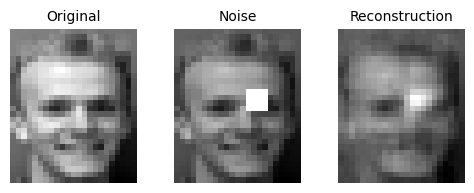

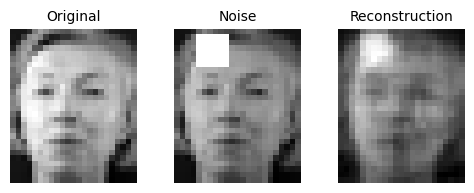

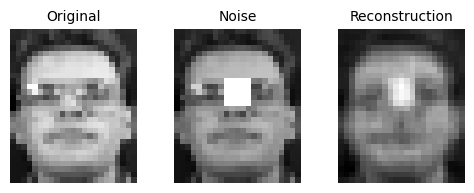

mse: 6.590, mse std: 0.016, acc: 0.511, acc std: 0.012, nmi: 0.654, nmi std: 0.011
time: 274 ms (started: 2023-10-08 00:06:53 +11:00)


In [73]:
# print results
print_evaluation_results(l21_block_models,l21_block_index_maps,l21_block_metrics,X_hat,X_block_noise,img_size)

##### 6.1.2 L2,1-Norm based NMF, Pepper & Salt Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 86


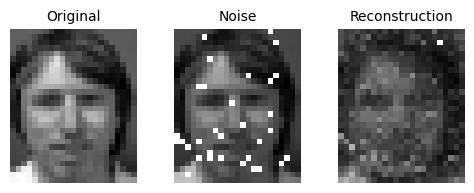

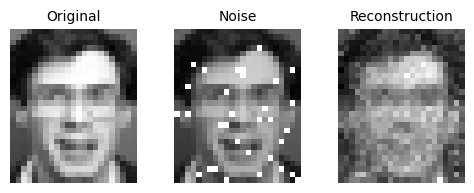

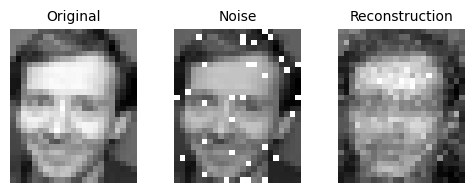

mse: 5.572, mse std: 0.015, acc: 0.663, acc std: 0.010, nmi: 0.788, nmi std: 0.011
time: 3min 27s (started: 2023-10-08 00:06:53 +11:00)


In [74]:
# fit the model
l21_salt_models, l21_salt_index_maps, l21_salt_metrics = train_multiple_times(X_hat, X_salt_noise.T, Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l21')

# print results
print_evaluation_results(l21_salt_models,l21_salt_index_maps,l21_salt_metrics,X_hat,X_salt_noise.T,img_size)

##### 6.1.3 Robust NMF via L1 Norm Reg, Block Noise, with different lambdas

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 107


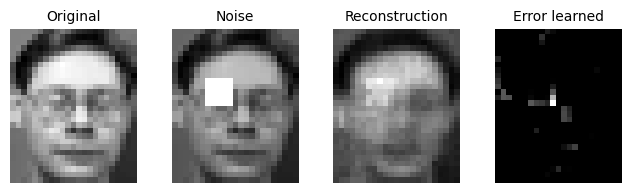

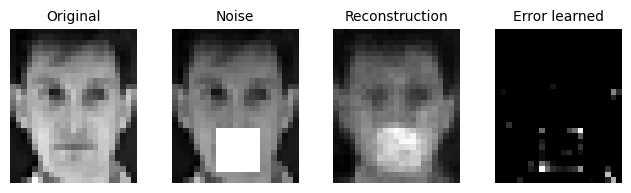

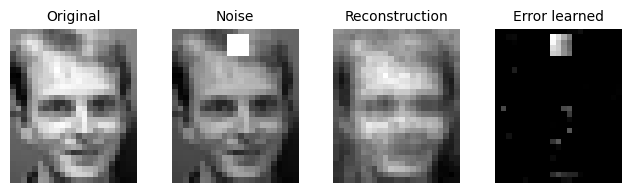

mse: 5.908, mse std: 0.104, acc: 0.609, acc std: 0.013, nmi: 0.735, nmi std: 0.014
time: 3min 57s (started: 2023-10-08 00:10:20 +11:00)


In [75]:
# fit the model
l1reg_block_models, l1reg_block_index_maps, l1reg_block_metrics = train_multiple_times(X_hat, X_block_noise, Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l1reg')

# print results
print_evaluation_results(l1reg_block_models, l1reg_block_index_maps, l1reg_block_metrics,X_hat,X_block_noise,img_size)

In [76]:
# fit the model
l1reg_block_models_006, l1reg_block_index_maps_006, l1reg_block_metrics_006 = train_multiple_times(X_hat, X_block_noise, Y_hat, fit_params_006, sample_ratio=0.9, n_times=n_times, algo='l1reg')

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
time: 3min 58s (started: 2023-10-08 00:14:18 +11:00)


In [77]:
# fit the model
l1reg_block_models_004, l1reg_block_index_maps_004, l1reg_block_metrics_004 = train_multiple_times(X_hat, X_block_noise, Y_hat, fit_params_004, sample_ratio=0.9, n_times=n_times, algo='l1reg')

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
time: 4min 1s (started: 2023-10-08 00:18:16 +11:00)


In [78]:
# fit the model
l1reg_block_models_0, l1reg_block_index_maps_0, l1reg_block_metrics_0 = train_multiple_times(X_hat, X_block_noise, Y_hat, fit_params_0, sample_ratio=0.9, n_times=n_times, algo='l1reg')

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
time: 4min 45s (started: 2023-10-08 00:22:18 +11:00)


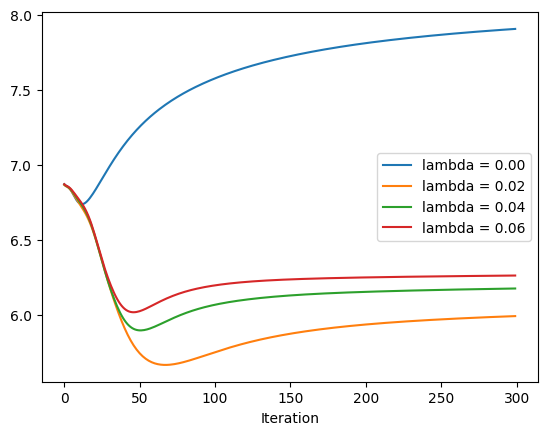

time: 123 ms (started: 2023-10-08 01:07:27 +11:00)


In [79]:
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_block_models_0], axis=0), label='lambda = 0.00')
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_block_models], axis=0), label='lambda = 0.02')
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_block_models_004], axis=0), label='lambda = 0.04')
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_block_models_006], axis=0), label='lambda = 0.06')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

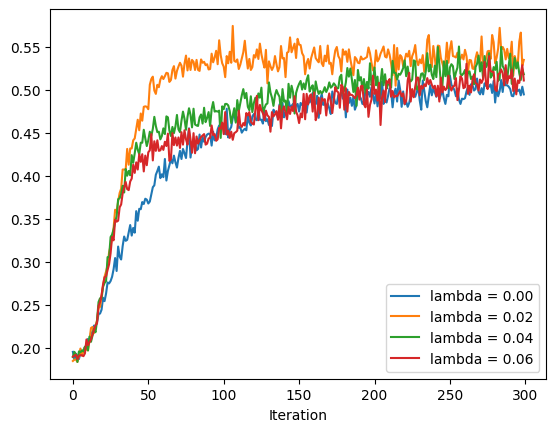

time: 107 ms (started: 2023-10-08 01:07:27 +11:00)


In [80]:
plt.plot(np.mean([m.error_['acc'] for m in l1reg_block_models_0], axis=0), label='lambda = 0.00')
plt.plot(np.mean([m.error_['acc'] for m in l1reg_block_models], axis=0), label='lambda = 0.02')
plt.plot(np.mean([m.error_['acc'] for m in l1reg_block_models_004], axis=0), label='lambda = 0.04')
plt.plot(np.mean([m.error_['acc'] for m in l1reg_block_models_006], axis=0), label='lambda = 0.06')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

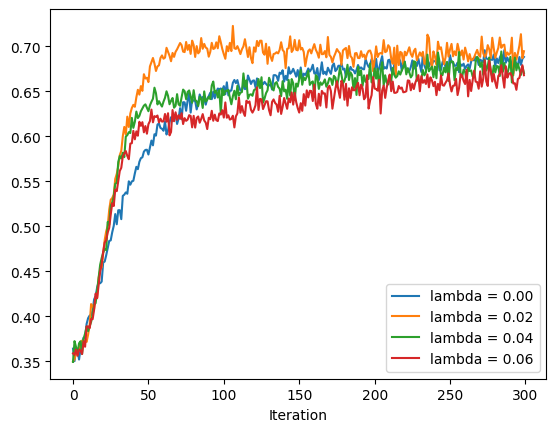

time: 80.1 ms (started: 2023-10-08 01:07:27 +11:00)


In [81]:
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_block_models_0], axis=0), label='lambda = 0.00')
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_block_models], axis=0), label='lambda = 0.02')
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_block_models_004], axis=0), label='lambda = 0.04')
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_block_models_006], axis=0), label='lambda = 0.06')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

##### 6.1.4 Robust NMF via L1 Norm Reg + Pepper, Pepper & Salt Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 262


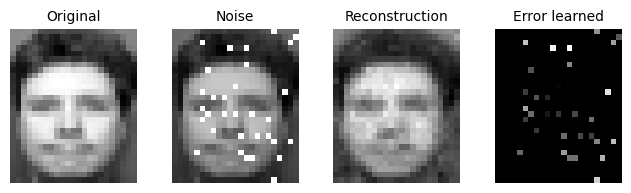

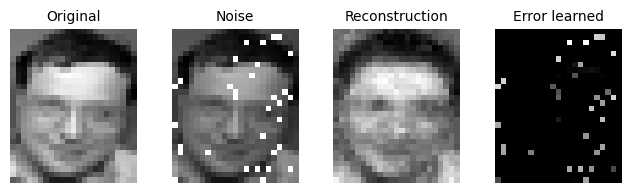

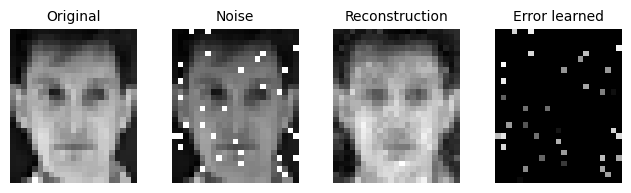

mse: 4.317, mse std: 0.078, acc: 0.772, acc std: 0.013, nmi: 0.868, nmi std: 0.005
time: 4min 12s (started: 2023-10-08 01:07:28 +11:00)


In [82]:
# fit the model
l1reg_salt_models, l1reg_salt_index_maps, l1reg_salt_metrics = train_multiple_times(X_hat, X_salt_noise.T, Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l1reg')

# print results
print_evaluation_results(l1reg_salt_models, l1reg_salt_index_maps, l1reg_salt_metrics,X_hat,X_salt_noise.T,img_size)

##### 6.1.5 L2,1-Norm, L1-Norm regularised robust NMF comparison

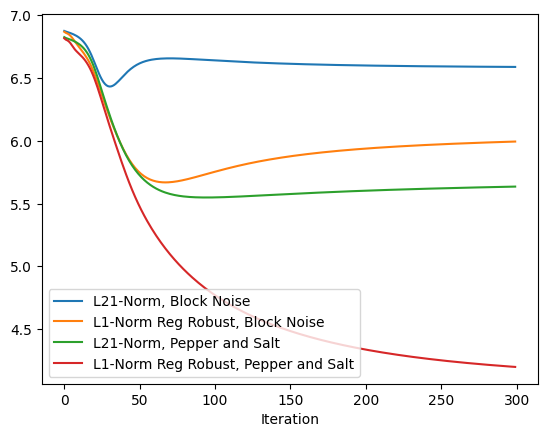

time: 138 ms (started: 2023-10-08 01:11:40 +11:00)


In [83]:
plt.plot(np.mean([m.error_['rmse'] for m in l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_block_models], axis=0), label='L1-Norm Reg Robust, Block Noise')
plt.plot(np.mean([m.error_['rmse'] for m in l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['rmse'] for m in l1reg_salt_models], axis=0), label='L1-Norm Reg Robust, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

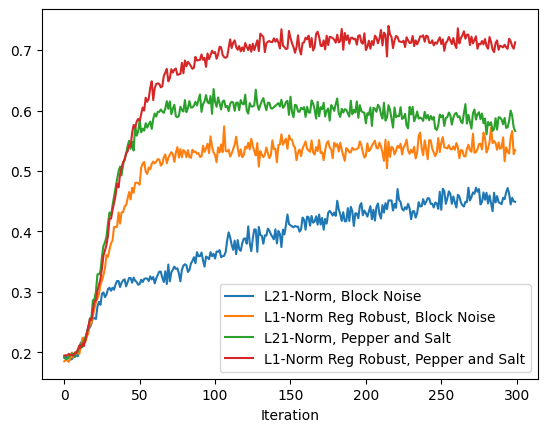

time: 81.1 ms (started: 2023-10-08 01:11:40 +11:00)


In [84]:
plt.plot(np.mean([m.error_['acc'] for m in l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['acc'] for m in l1reg_block_models], axis=0), label='L1-Norm Reg Robust, Block Noise')
plt.plot(np.mean([m.error_['acc'] for m in l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['acc'] for m in l1reg_salt_models], axis=0), label='L1-Norm Reg Robust, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

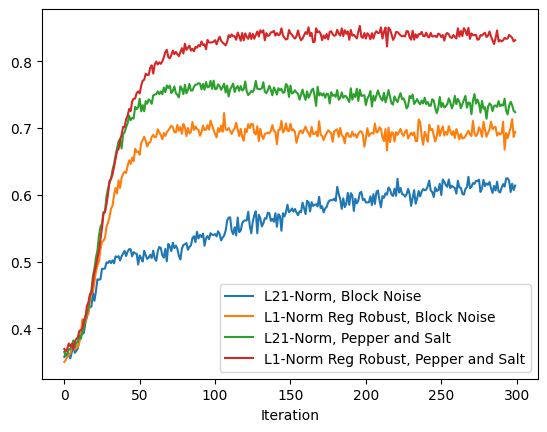

time: 73.1 ms (started: 2023-10-08 01:11:40 +11:00)


In [85]:
plt.plot(np.mean([m.error_['nmi'] for m in l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_block_models], axis=0), label='L1-Norm Reg Robust, Block Noise')
plt.plot(np.mean([m.error_['nmi'] for m in l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['nmi'] for m in l1reg_salt_models], axis=0), label='L1-Norm Reg Robust, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

#### 6.2 YaleB Dataset

In [86]:
# load YaleB dataset
Yaleb_X_hat, Yaleb_X_data, Yaleb_Y_hat = load_data(root=DATA_ROOT+'data/CroppedYaleB', reduce=4)
Yaleb_img_size = Yaleb_X_data[0].shape


# generate Block noise data
Yaleb_X_block_noise = np.zeros(Yaleb_X_hat.shape)
for i in range(Yaleb_X_hat.shape[1]):
    Yaleb_X_block_noise[:,i] = BlockOcclusion(Yaleb_img_size).occlusde(Yaleb_X_hat[:,i])


# generate Salt noise data, note that the dimension is transposed!!!
Yaleb_X_salt_noise = transform21d(gen_salt_pepper_noise(Yaleb_X_data, 0.05))

time: 714 ms (started: 2023-10-08 01:11:40 +11:00)


##### 6.2.1 L2,1-Norm NMF, Block Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 291


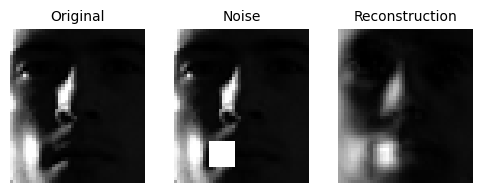

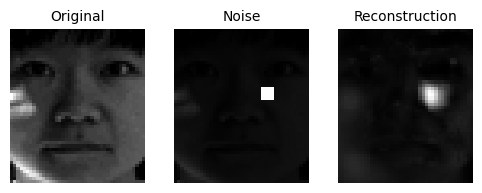

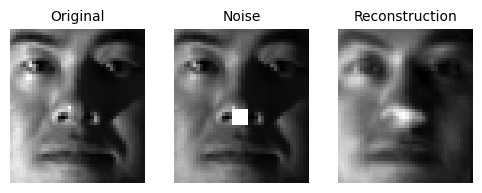

mse: 5.003, mse std: 0.005, acc: 0.246, acc std: 0.005, nmi: 0.296, nmi std: 0.013
time: 29min 51s (started: 2023-10-08 01:11:41 +11:00)


In [87]:
# fit the model
yaleb_l21_block_models, yaleb_l21_block_index_maps, yaleb_l21_block_metrics = train_multiple_times(Yaleb_X_hat, Yaleb_X_block_noise, Yaleb_Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l21')

# print results
print_evaluation_results(yaleb_l21_block_models, yaleb_l21_block_index_maps, yaleb_l21_block_metrics,Yaleb_X_hat,Yaleb_X_block_noise,Yaleb_img_size)

##### 6.2.2 L2,1-Norm NMF, Pepper & Salt Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 276


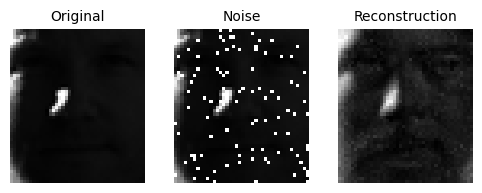

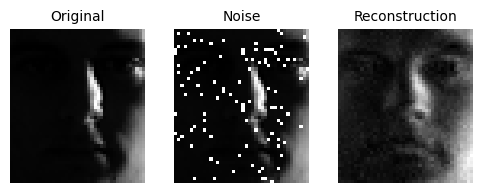

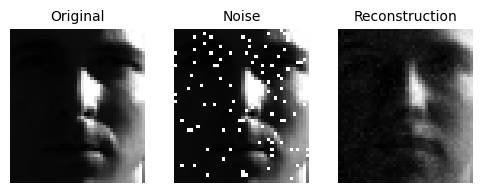

mse: 4.361, mse std: 0.009, acc: 0.295, acc std: 0.004, nmi: 0.359, nmi std: 0.008
time: 32min 46s (started: 2023-10-08 01:41:32 +11:00)


In [88]:
# fit the model
yaleb_l21_salt_models, yaleb_l21_salt_index_maps, yaleb_l21_salt_metrics = train_multiple_times(Yaleb_X_hat, Yaleb_X_salt_noise.T, Yaleb_Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l21')

# print results
print_evaluation_results(yaleb_l21_salt_models, yaleb_l21_salt_index_maps, yaleb_l21_salt_metrics,Yaleb_X_hat,Yaleb_X_salt_noise.T,Yaleb_img_size)

##### 6.2.3 Robust NMF via L1 Norm Reg, Block Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 207


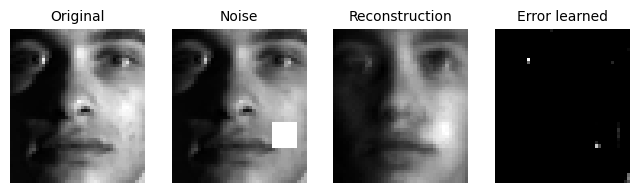

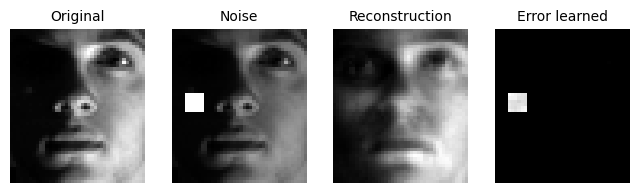

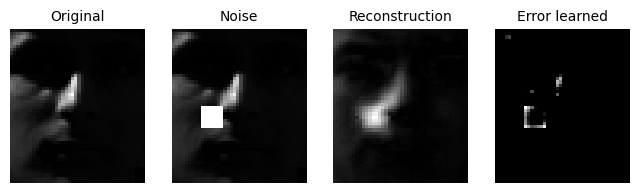

mse: 4.592, mse std: 0.014, acc: 0.268, acc std: 0.010, nmi: 0.322, nmi std: 0.011
time: 1h 13min 59s (started: 2023-10-08 05:13:29 +11:00)


In [89]:
# fit the model
yaleb_l1reg_block_models, yaleb_l1reg_block_index_maps, yaleb_l1reg_block_metrics = train_multiple_times(Yaleb_X_hat, Yaleb_X_block_noise, Yaleb_Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l1reg')

# print results
print_evaluation_results(yaleb_l1reg_block_models, yaleb_l1reg_block_index_maps, yaleb_l1reg_block_metrics,Yaleb_X_hat,Yaleb_X_block_noise,Yaleb_img_size)

##### 6.2.4 Robust NMF via L1 Norm Reg, Pepper & Salt Noise

training model on sample data 1
training model on sample data 2
training model on sample data 3
training model on sample data 4
training model on sample data 5
training finished.
best performance with model 5 at iteration 298


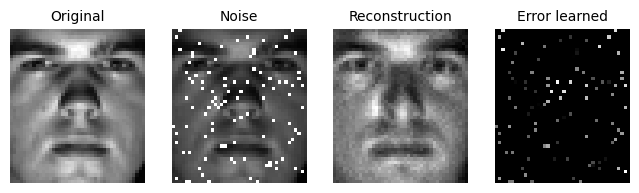

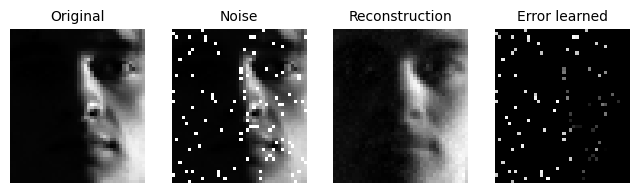

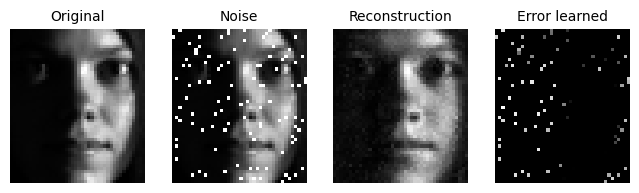

mse: 4.030, mse std: 0.013, acc: 0.299, acc std: 0.005, nmi: 0.351, nmi std: 0.010
time: 1h 6min 38s (started: 2023-10-08 10:43:02 +11:00)


In [90]:
# fit the model
yaleb_l1reg_salt_models, yaleb_l1reg_salt_index_maps, yaleb_l1reg_salt_metrics = train_multiple_times(Yaleb_X_hat, Yaleb_X_salt_noise.T, Yaleb_Y_hat, fit_params, sample_ratio=0.9, n_times=n_times, algo='l1reg')

# print results
print_evaluation_results(yaleb_l1reg_salt_models, yaleb_l1reg_salt_index_maps, yaleb_l1reg_salt_metrics,Yaleb_X_hat,Yaleb_X_salt_noise.T,Yaleb_img_size)

##### 6.2.5 L2,1-Norm, L1-Norm regularised robust NMF comparison

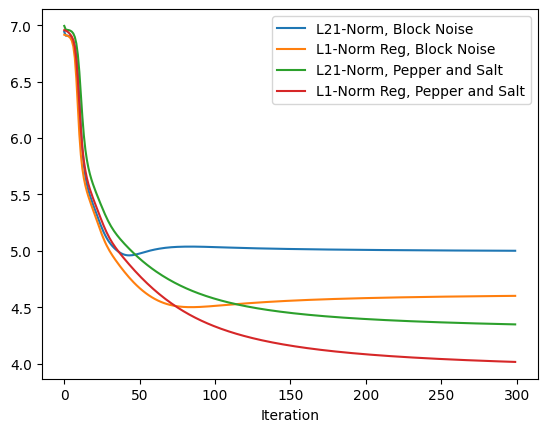

time: 106 ms (started: 2023-10-08 11:49:41 +11:00)


In [91]:
plt.plot(np.mean([m.error_['rmse'] for m in yaleb_l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['rmse'] for m in yaleb_l1reg_block_models], axis=0), label='L1-Norm Reg, Block Noise')
plt.plot(np.mean([m.error_['rmse'] for m in yaleb_l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['rmse'] for m in yaleb_l1reg_salt_models], axis=0), label='L1-Norm Reg, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

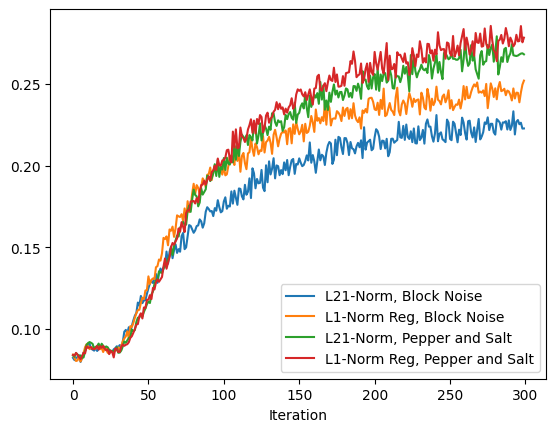

time: 83.2 ms (started: 2023-10-08 11:49:41 +11:00)


In [92]:
plt.plot(np.mean([m.error_['acc'] for m in yaleb_l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['acc'] for m in yaleb_l1reg_block_models], axis=0), label='L1-Norm Reg, Block Noise')
plt.plot(np.mean([m.error_['acc'] for m in yaleb_l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['acc'] for m in yaleb_l1reg_salt_models], axis=0), label='L1-Norm Reg, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()

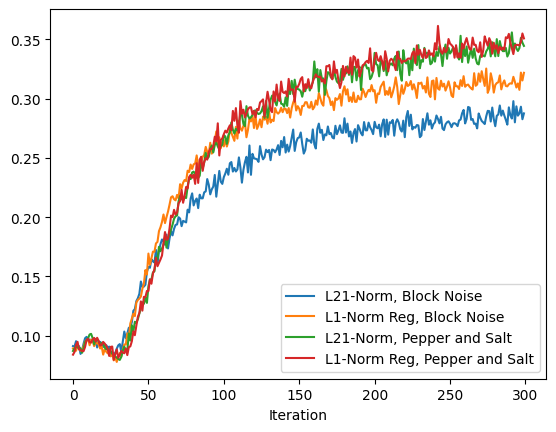

time: 74.1 ms (started: 2023-10-08 11:49:41 +11:00)


In [93]:
plt.plot(np.mean([m.error_['nmi'] for m in yaleb_l21_block_models], axis=0), label='L21-Norm, Block Noise')
plt.plot(np.mean([m.error_['nmi'] for m in yaleb_l1reg_block_models], axis=0), label='L1-Norm Reg, Block Noise')
plt.plot(np.mean([m.error_['nmi'] for m in yaleb_l21_salt_models], axis=0), label='L21-Norm, Pepper and Salt')
plt.plot(np.mean([m.error_['nmi'] for m in yaleb_l1reg_salt_models], axis=0), label='L1-Norm Reg, Pepper and Salt')
plt.xlabel('Iteration')
plt.ylabel('')
plt.legend()
plt.show()